In [1]:
import os
GPU_id = 3
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import sys
sys.path.insert(1, '../')

In [3]:
import torch
import pandas as pd
import numpy as np
from time import time 

from fastai import *
from fastai.basic_data import *
from fastai.basic_data import *
from fastai.tabular import *
from fastai.basic_data import DataBunch
from fastai.tabular import TabularModel

import cudf

import nv_tabular as nvt
from nv_tabular.ops import Normalize, FillMissing, Categorify, Moments, Median, Encoder, LogOp, ZeroFill
from nv_tabular.batchloader import FileItrDataset, DLCollator, DLDataLoader

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [4]:
torch.__version__, cudf.__version__

('1.5.0.dev20200304', '0.13.0a+3190.gac8aabfee')

In [5]:
%load_ext snakeviz
# load snakeviz if you want to run profiling

In [6]:
# to_cpu = True

<h3> Dataset Gathering: Define files in the training and validation datasets. </h3>

In [7]:
# data_path = '/rapids/notebooks/jperez/Documents/ds-itr/examples/'
data_path = '/datasets/outbrain/jp_out/output/'
#df_test = 'test/'
df_valid = 'validation_feature_vectors_integral.csv/'
df_train = 'train_feature_vectors_integral_eval.csv/'

train_set = [data_path + df_train + x for x in os.listdir(data_path + df_train) if x.startswith("part")][:20] 
valid_set = [data_path + df_valid + x for x in os.listdir(data_path + df_valid) if x.startswith("part")][:5] 

In [8]:
len(train_set), len(valid_set)

(20, 5)

<h4>Grab column information</h4>

In [9]:
cols = open(data_path + 'train_feature_vectors_integral_eval.csv.header').read().splitlines()

In [10]:
cat_names = ['display_id', 'is_leak', 'doc_event_id', 'ad_id', 'doc_id', 'doc_ad_entity_id', 'doc_event_entity_id', 'doc_event_entity_id', 'doc_ad_source_id', 'doc_event_source_id', 'event_geo_location', 'ad_advertiser', 'event_country_state', 'doc_ad_publisher_id', 'doc_event_publisher_id', 'doc_ad_topic_id', 'doc_event_topic_id', 'event_country', 'doc_ad_category_id', 'doc_event_category_id', 'event_hour', 'event_platform', 'traffic_source', 'event_weekend', 'user_has_already_viewed_doc']
cont_names =  ['pop_ad_id_conf', 'pop_document_id_conf', 'user_doc_ad_sim_categories_conf', 'user_doc_ad_sim_topics_conf', 'pop_publisher_id_conf', 'pop_advertiser_id_conf', 'pop_campaign_id_conf', 'pop_source_id_conf', 'pop_entity_id_conf', 'pop_topic_id_conf', 'pop_category_id_conf', 'pop_ad_id', 'pop_document_id', 'pop_publisher_id', 'pop_advertiser_id', 'pop_campaign_id', 'pop_source_id', 'pop_entity_id', 'pop_topic_id', 'pop_category_id', 'user_doc_ad_sim_categories', 'user_doc_ad_sim_topics', 'user_doc_ad_sim_entities', 'doc_event_doc_ad_sim_categories', 'doc_event_doc_ad_sim_topics', 'doc_event_doc_ad_sim_entities', 'user_views', 'ad_views', 'doc_views', 'doc_event_days_since_published', 'doc_event_hour', 'doc_ad_days_since_published'] #+ [i for i in ds.columns if i not in cat_names and i not in ['label']]
cat_names = [name for name in cat_names if name in cols]
cont_names = [name for name in cont_names if name in cols]


<h3>Preprocessing:</h3> <p>Select operations to perform, create the Preprocessor object, create dataset iterator object and collect the stats on the training dataset</p>

In [11]:
freq_threshes = {}
for x in cat_names:
    freq_threshes[x] = 1
freq_threshes

{'display_id': 1,
 'is_leak': 1,
 'doc_event_id': 1,
 'ad_id': 1,
 'doc_id': 1,
 'doc_ad_source_id': 1,
 'doc_event_source_id': 1,
 'event_geo_location': 1,
 'ad_advertiser': 1,
 'event_country_state': 1,
 'doc_ad_publisher_id': 1,
 'doc_event_publisher_id': 1,
 'event_country': 1,
 'event_hour': 1,
 'event_platform': 1,
 'traffic_source': 1,
 'event_weekend': 1,
 'user_has_already_viewed_doc': 1}

In [13]:
%%time
proc = nvt.Workflow(cat_names=cat_names, cont_names=cont_names, label_name=['label'], to_cpu=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 27.9 µs


In [14]:
proc.add_cont_preprocess([FillMissing(), Normalize()])
proc.add_cat_preprocess(Categorify(use_frequency=True, freq_threshold=1))

In [15]:
%%time
trains_itrs = nvt.dataset(train_set,names=cols, engine='csv')
valids_itrs = nvt.dataset(valid_set,names=cols, engine='csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.3 µs


In [16]:
output_path_train = './jp_outbrains/train'
output_path_valid = './jp_outbrains/valid'

In [17]:
%%time
proc.apply(trains_itrs, apply_offline=True, record_stats=True, output_path=output_path_train, shuffle=False)

CPU times: user 1min, sys: 39.4 s, total: 1min 39s
Wall time: 1min 44s


In [18]:
%%time
proc.apply(valids_itrs, apply_offline=True, record_stats=False, output_path=output_path_valid, shuffle=False)

CPU times: user 9.83 s, sys: 8.34 s, total: 18.2 s
Wall time: 19.6 s


In [19]:
new_train_set = [os.path.join(output_path_train, x) for x in os.listdir(output_path_train) if x.endswith("parquet")]
new_valid_set = [os.path.join(output_path_valid, x) for x in os.listdir(output_path_valid) if x.endswith("parquet")]

<h5>Gather embeddings using statistics gathered in the Read phase.</h5>

In [20]:
embeddings = [x[1] for x in proc.df_ops['Categorify'].get_emb_sz(proc.stats["categories"], proc.columns_ctx['categorical']['base'])]

In [21]:
embeddings

[(198770, 16),
 (3699, 16),
 (1159427, 16),
 (212566, 16),
 (76718, 16),
 (5895, 16),
 (3518, 16),
 (754, 16),
 (473, 16),
 (1273, 16),
 (975, 16),
 (214, 16),
 (8, 5),
 (5, 4),
 (4, 3),
 (3, 3),
 (5, 4),
 (4, 3)]

<h5>Create the file iterators using the FileItrDataset Class.</h5>

In [22]:
%%time
t_batch_sets = [FileItrDataset(x, names=cols, engine='parquet', batch_size=400000) for x in new_train_set]
v_batch_sets = [FileItrDataset(x, names=cols, engine='parquet', batch_size=400000) for x in new_valid_set]

CPU times: user 2.43 s, sys: 3.44 s, total: 5.87 s
Wall time: 6.04 s


In [23]:
%%time
t_chain = torch.utils.data.ChainDataset(t_batch_sets)
v_chain = torch.utils.data.ChainDataset(v_batch_sets)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.4 µs


In [24]:
proc.columns_ctx['final']['ctx']

{'continuous': ['Normalize'],
 'categorical': ['Categorify'],
 'label': ['label']}

<h5>Use the Deep Learning Collator to create a collate function to pass to the dataloader.</h5>

In [25]:
%%time
dlc = DLCollator(preproc=proc, apply_ops=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs


In [26]:
%%time
t_data = DLDataLoader(t_chain, collate_fn=dlc.gdf_col, pin_memory=False, num_workers=0)
v_data = DLDataLoader(v_chain, collate_fn=dlc.gdf_col, pin_memory=False, num_workers=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 196 µs


<h4>After creating the Dataloaders you can leverage fastai framework to create Machine Learning models</h4>

In [27]:
databunch = DataBunch(t_data, v_data, collate_fn=dlc.gdf_col, device="cuda")

In [28]:
%%time
model = TabularModel(emb_szs = embeddings, n_cont=len(cont_names), out_sz=2, layers=[512,256])

learn =  Learner(databunch, model, metrics=[accuracy])
learn.loss_func = torch.nn.CrossEntropyLoss()


CPU times: user 14 s, sys: 1.27 s, total: 15.3 s
Wall time: 684 ms


In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.45E-02


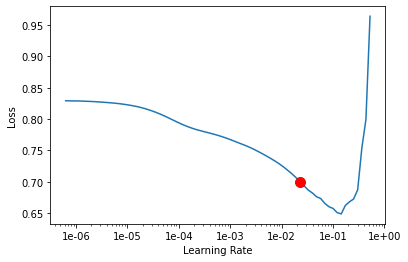

In [30]:
learn.recorder.plot(show_moms=True, suggestion=True)

In [31]:
learning_rate = 2.75e-2
epochs = 1

In [32]:
start = time()
learn.fit_one_cycle(epochs,learning_rate)
t_final = time() - start 

epoch,train_loss,valid_loss,accuracy,time
0,0.472148,0.439142,0.812843,00:40


In [33]:
del learn 
del model
del databunch
torch.cuda.empty_cache() 